# Matched Field Processing

<img src="mfp.png" width="250px" style="float:left; padding-right:25px">


Matched Field Processing (MFP) is the generalisation of Beamforming. Instead of assuming plane waves and sampling the slowness domain, in MFP specific potential source locations (★) sampled. For each sampled location synthetic traveltimes $t(\vec{x}_i, \vec{x}_s)$ to the stations $x_i$ are computed. From these travel times, simple analytical Green's Functions of the form $s(\vec{x}_i, \vec{x}_s, \omega) = \exp(-i\omega t(\vec{x}_i, \vec{x}_s))$ are computed as the synthetic wavefield and the **match** between the **synthetic wavefield** (Green's Functions) and the **recorded wavefield** (Seismograms) is measured.

In this notebook, the MFP algorithm is demonstrated step-by-step:

1. **Generate a synthetic data example**. We use simple ricker wavelets for demonstration purposes.
2. **Define a grid geometry** of potential source locations.
3. **Compute and visualize synthetic Green's Functions** of the form $e^{-i\omega t}$ for a sample grid cell.
4. **Compute and visualize beampowers** using the conventional beamformer for all grid cells.

## Step 1: Generate a synthetic data example

In [193]:
import numpy as np
import obspy
import pylab as plt
import matplotlib.gridspec as gridspec
from scipy.signal import ricker, fftconvolve

# define station locations x, y
stations = np.array([
    [5, -4.33],
    [-5, -4.33],
    [0, 4.33],
])

# define the source location x, y
source = np.array([15, 15])

# define the source wavelet
freq = 20
maxtime = 100
times = np.arange(0, maxtime, 1 / freq)
wavelet = np.real(ricker(len(times), freq / 3))

# velocity of the medium
vel = 3

# compute source-station distances
distances = np.linalg.norm(stations - source, ord=2, axis=1)

# create empty medium responses
responses = [np.zeros(times.shape) for _ in stations]

for dist, response in zip(distances, responses):
    # the response of an isotropic, homogeneous half-space
    # is 1 at the expected arrival time of the direct wave.
    # There are no reflections or other effects.
    nearest_time_for_arrival = np.abs(times - (dist / vel))
    response[np.argmin(nearest_time_for_arrival)] = 1

# waveforms are the convolution of source wavelet with the medium responses
waveforms = [fftconvolve(wavelet, response, mode="same") for response in responses]

## Step 1.1: Visualise station geometry and synthetic waveforms

<AxesSubplot:xlabel='Distance [km]', ylabel='Distance [km]'>

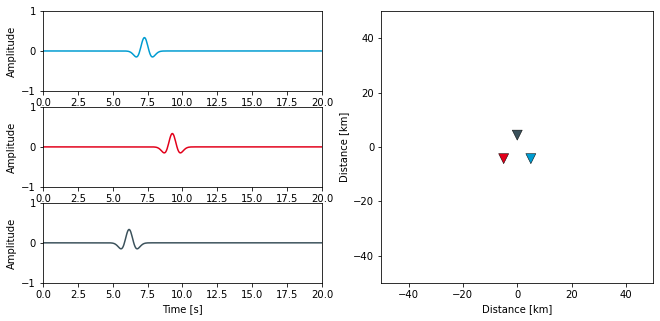

In [194]:
# define UHH colors to distinguish stations
sta_colors = ["#009CD1", "#E2001A", "#3B515B"]


def plot_overview(stations, times, waveforms, synth_waveforms=None):
    """Function to plot seismograms and station geometry. Returns the ax of the map view for further use."""
    # instantiate figure
    fig = plt.figure(figsize=(11, 5))
    spec = gridspec.GridSpec(ncols=2, nrows=len(waveforms), figure=fig)

    # axes for seismograms
    seismo_axs = [fig.add_subplot(spec[i, 0]) for i, _ in enumerate(waveforms)]
    # plot seismograms onto these axes
    for waveform, color, ax in zip(waveforms, sta_colors, seismo_axs):
        ax.plot(times, waveform, color=color)
        ax.set_ylim(-1, 1)
        ax.set_ylabel("Amplitude")
        ax.set_xlim(0, 20)

    if synth_waveforms is not None:
        for waveform, color, ax in zip(synth_waveforms, sta_colors, seismo_axs):
            ax.plot(times, waveform, color=color, alpha=.5)
    
    ax.set_xlabel("Time [s]")

    # add subplot for map view
    ax = fig.add_subplot(spec[:, 1])
    ax.set_aspect("equal")

    ax.scatter(*stations.T, marker="v", s=100, c=sta_colors, ec="k", lw=0.5)

    ax.set_xlim(-50, 50)
    ax.set_ylim(-50, 50)

    ax.set_xlabel("Distance [km]")
    ax.set_ylabel("Distance [km]")

    return ax

plot_overview(stations, times, waveforms)

Even without precise knowledge of the source or following any algorithm, we can already estimate visually from which general direction the wave field must arrive from. The signal arrives last at the red station, which limits the possible source locations to the top right.

---

## Step 2: Define a grid geometry

Most commonly, MFP is simply a grid search over pre-defined potential source locations. For this, we need to define the locations we want to test.

In [195]:
from itertools import product
def generate_gridpoints(grid_limits_x, grid_limits_y, grid_spacing):
    """ Generates a square homogeneous grid in the bounds given by grid_limits_x/y and with spacing grid_spacing. """    
    # compute the x- and y-coordinates
    grid_x_coords = np.arange(grid_limits_x[0], grid_limits_x[1] + grid_spacing, grid_spacing)
    grid_y_coords = np.arange(grid_limits_y[0], grid_limits_y[1] + grid_spacing, grid_spacing)

    # gridpoints are the product of all x- and y-coordinate combinations
    grid_points = product(grid_x_coords, grid_y_coords)

    # get array from list from iterator 
    grid_points = np.asarray(list(grid_points))
    
    return grid_points, grid_x_coords, grid_y_coords

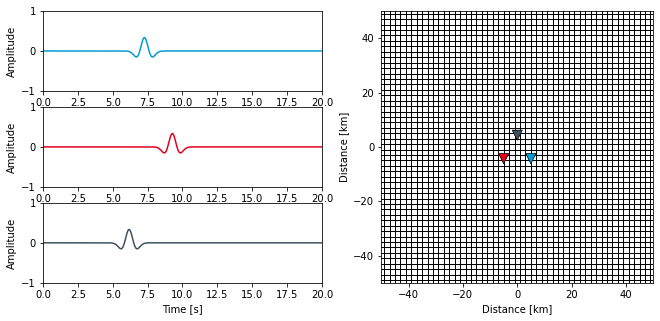

In [196]:
# choose the grid geometry
grid_spacing = 2
grid_limits = (-50, 50)

# compute the grid geometry
grid_points, grid_x_coords, grid_y_coords = generate_gridpoints(
    grid_limits_x=grid_limits, 
    grid_limits_y=grid_limits,
    grid_spacing=grid_spacing,
)

# replot the overview figure
ax = plot_overview(stations, times, waveforms)

# use pcolormesh to quickly visualize grid by plotting empty cells with a border.
xx, yy = np.meshgrid(grid_x_coords, grid_y_coords)
empty_cells = np.zeros(shape=len(grid_points)).reshape(len(grid_x_coords), len(grid_y_coords))
ax.pcolormesh(xx, yy, empty_cells, fc='None', ec='k', shading='nearest')

# plot the station locations again ontop of the grid
ax.scatter(*stations.T, marker='v', s=100, c=sta_colors, ec='k', lw=.5)

---

## Step 3: Compute and visualize synthetic Green's Functions

Now we can get started with MFP itself. For this, we need to a synthetic wave field (synthetic Green's function) to **match** the "recorded" wave field (that we computed in Step 1) against. To get a better understanding of what the synthetic wave fields that the "recorded" data is matched against actually look like, we pick a random cell and visualize.

[-32  32]


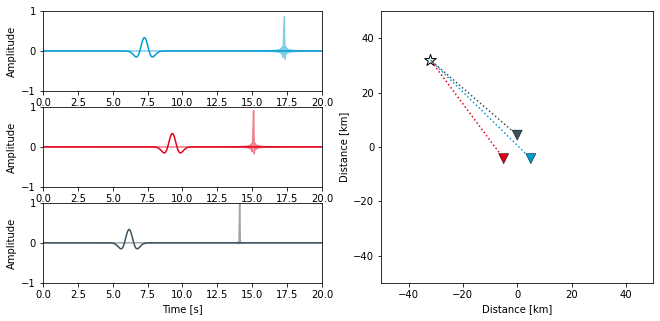

In [197]:
# pick any grid cell
idx_of_picked_cell = 500
gp = grid_points[idx_of_picked_cell]
print(gp)

# Compute expected traveltimes if that grid cell was the source location.
# At this point we have to chose how exactly we estimate the expected traveltime.
# Most commonly, a constant velocity for the entire medium is assumed.
# In this case, we know the correct velocity (v=3km/s) from above.
vel_const = 3
distances = np.linalg.norm(stations - gp, ord=2, axis=1)
traveltimes = distances / vel_const

# We compute synthetic wave fields (=analytical GFs) of the form s(x_i, x_s, ω) = exp(-iωt(x_i, x_s))
freqs = np.fft.fftfreq(len(times), d=1/freq)
omega = 2 * np.pi * freqs
synth_spectra = [np.exp(-1j * omega * tt) for tt in traveltimes]

# we convert the spectra to time-domain to be able to compare them against the "recorded" waveforms
synth_waveforms = [np.real(np.fft.ifft(synth_spectrum)) for synth_spectrum in synth_spectra]

# plot "recorded" and synethtic waveforms together and highlight cell
ax = plot_overview(stations, times, waveforms, synth_waveforms=synth_waveforms)

# mark the picked cell with a star and draw lines to stations
ax.scatter(*gp, s=150, marker="*", ec="k", fc="w")
for station, color in zip(stations, sta_colors):
    ax.plot(*list(zip(station, gp)), c=color, ls=":")

We find that the picked cell (index 500 by default) confirms what we have observed above. A source placed in the top left of the map can not be correct. The simple synthetic wave fields of the form $s(\vec{x}_i, \vec{x}_s, \omega) = \exp(-i\omega t(\vec{x}_i, \vec{x}_s))$ (which in time-domain resemble Dirac-$\delta$ functions) show the wrong order of arrival. We see that a source placed in the top left results in waves arriving on the red station before the blue station. The "recorded" data shows that the red station should be reached last. We also already see that the source should lie closer than our test.

---

## Step 4: Compute beampowers for the entire grid

To now systematically test all possible locations, we perform MFP as a grid search. That is quantifying the match between the synthetic and "recorded" wave fields for each potential source location, i.e., the grid. For this, we follow these steps:

**Step 4.1**: Transform the seismograms into the frequency domain $d_i(t) \rightarrow d_i(\omega)$.

**Step 4.2**: Compute the cross-spectral density matrix $K_{ij}(\omega) = d_i(\omega) d_j^*(\omega)$, with $*$ the complex conjugate.

**Step 4.3**: For each grid cell, compute the beampower using the conventional beamformer

$B = \sum_\omega s_{i}^*(\omega, a) K_{ij}(\omega) s_{j}(\omega, a)$.

The indices here are used in Einstein summation convention: Repeating indices are summed over. For more information, see our manuscript.

In [198]:
# Step 4.1 convert seismograms into frequency domain
data_spectra = np.array([np.fft.fft(waveform) for waveform in waveforms])

# Step 4.2 compute cross-spectral density matrix (using einsum for speed)
K = np.einsum('iw,jw->ijw', data_spectra, np.conj(data_spectra))

# # explicit for-loop version of csdm-computation for clarity (slower)
# K = np.zeros(shape=(len(waveforms), len(waveforms), data_spectra.shape[1])).astype(complex)
# for i, data_spectrum_a in enumerate(data_spectra):
#     for j, data_spectrum_b in enumerate(data_spectra):
#         K[i, j] = data_spectrum_a * np.conj(data_spectrum_b)

# Initialize an empty list to save beampowers into
beampowers = []
for gp in grid_points:
    # compute traveltime from gridpoint-station distance
    # copy&paste from Step 3
    distances = np.linalg.norm((stations - gp), ord=2, axis=1)
    traveltimes = distances / vel_const

    # get synthetic GFs for the same frequencies/length as "recorded" data
    f = np.fft.fftfreq(len(times), d=1/freq)
    omega = 2 * np.pi * f
    synth_spectra = [np.exp(-1j * omega * tt) for tt in traveltimes]

    # Step 4.3
    # conventional beamformer using numpy's einsum() function for speed and readability
    beampower = np.sum(np.real(np.einsum('iw,ijw,jw->w', np.conj(synth_spectra), K, synth_spectra)))

    # # explicit for-loop version of conventional beamformer for clarity (slower)
    # bp_tmp = []
    # for i, synth_spectrum_i in enumerate(synth_spectra):
    #     for j, synth_spectrum_j in enumerate(synth_spectra):
    #         bp_tmp.append(np.real(np.conj(synth_spectrum_i) * K[i, j] * synth_spectrum_j))
    # beampower = np.sum(bp_tmp)

    beampowers.append(beampower)

# extract beampower peak (resolved source location)
bp_peak = grid_points[np.where(beampowers == np.max(beampowers))]

# Compute synthetic waveforms for best-fitting gridpoint
# copy&paste from Step 3
distances = np.linalg.norm(stations - bp_peak, ord=2, axis=1)
traveltimes = distances / vel_const
synth_spectra = [np.exp(-1j * omega * tt) for tt in traveltimes]
synth_waveforms = [np.real(np.fft.ifft(synth_spectrum)) for synth_spectrum in synth_spectra]

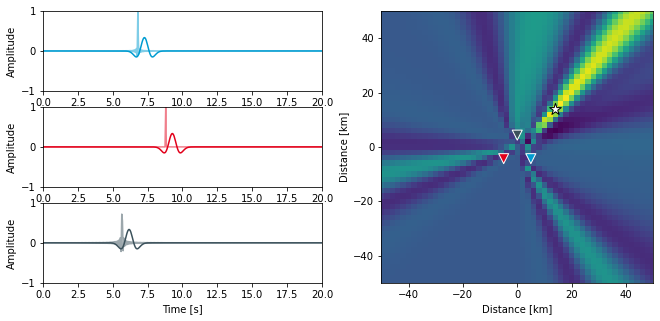

In [199]:
# plot results
ax = plot_overview(stations, times, waveforms, synth_waveforms=synth_waveforms)
xx, yy = np.meshgrid(grid_x_coords, grid_y_coords)
bps = np.array(beampowers).reshape(len(grid_x_coords), len(grid_y_coords)).T
ax.pcolormesh(xx, yy, bps, shading="nearest")

# mark the highest beampower
ax.scatter(*bp_peak.T, s=150, marker="*", ec="k", fc="w")

# replot stations on top
ax.scatter(*stations.T, marker="v", s=100, c=sta_colors, ec="w", lw=1)